In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   146M      0  0:00:05  0:00:05 --:--:--  151M


In [ ]:
# !unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip  'MSR-LA - 3467.docx'  'readme[1].txt'
 logs			       PetImages	     sample_data


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    color_mode="rgb",
    subset="training",
    label_mode = 'binary',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    color_mode="rgb",
    subset="validation",
    label_mode = 'binary',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


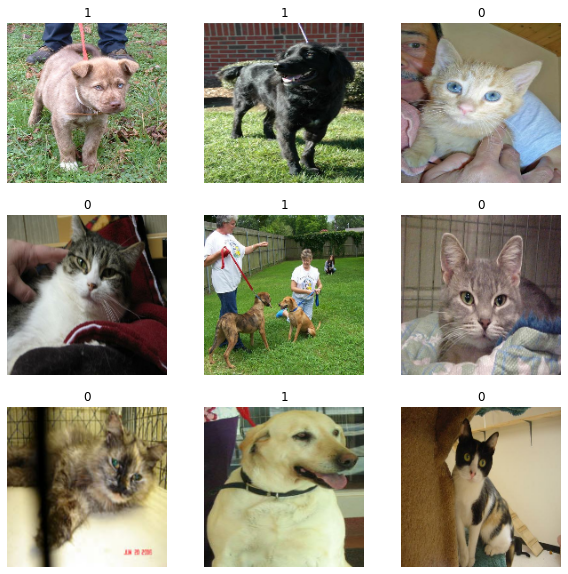

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.5,
#     height_shift_range=0.5,
#     horizontal_flip=True)



In [ ]:
data_augmentation = keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomWidth(
    0.5, interpolation='bilinear', seed=None, name=None),
        tf.keras.layers.experimental.preprocessing.RandomHeight(
    0.5, interpolation='bilinear', seed=None, name=None)
    ]
)

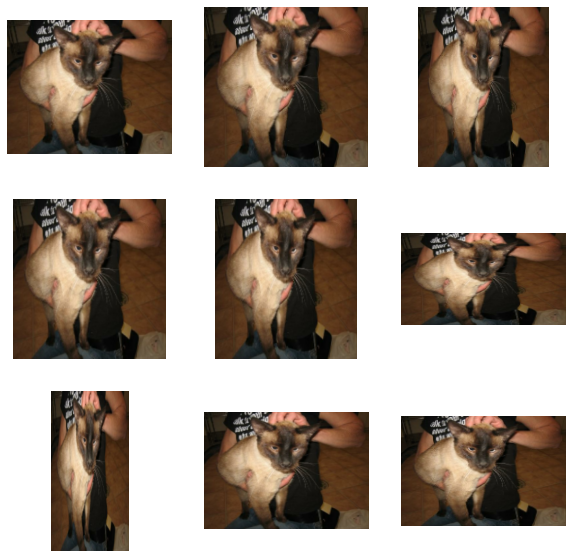

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
input_shape = (180, 180, 3)

resMod = ResNet50(
    include_top = False,
    input_shape=input_shape)


In [ ]:
from keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D
# lock the model
for layer in resMod.layers:
    layer.trainable = False
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)


# x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)
x = preprocess_input(x)
# x = layers.BatchNormalization()(x)
x = resMod(x)

# add a global averge pollinf layer
x = GlobalAveragePooling2D()(x)

# add a dense
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

# add a classifier
predictions = Dense(1, activation='sigmoid', name='predict')(x)

In [ ]:

# Create your own model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [ ]:
epochs = 5
from tensorboard.plugins.hparams import api as hp
import datetime

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tensorboard_callback]
)


Epoch 1/5
  1/586 [..............................] - ETA: 0s - loss: 1.7114 - accuracy: 0.4688WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
586/586 [==============================] - 155s 264ms/step - loss: 0.1892 - accuracy: 0.9406 - val_loss: 0.0447 - val_accuracy: 0.9816
Epoch 2/5
586/586 [==============================] - 115s 196ms/step - loss: 0.1149 - accuracy: 0.9545 - val_loss: 0.0518 - val_accuracy: 0.9795
Epoch 3/5
586/586 [==============================] - 100s 171ms/step - loss: 0.1117 - accuracy: 0.9583 - val_loss: 0.0446 - val_accuracy: 0.9825
Epoch 4/5
586/586 [==============================] - 92s 157ms/step - loss: 0.0989 - accuracy: 0.9613 - val_loss: 0.0444 - val_accuracy: 0.9810
Epoch 5/5
586/586 [==============================] - 87s 14

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "ResNet" \
  --description "Training"\
  --one_shot

2020-12-14 04:09:20.512090: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/55lKnbr6Q5aUYUemOj3Elg/

[2020-12-14T04:09:22] Uploader started.
[2020-12-14T04:09:37] Total uploaded: 32 scalars, 2593 tensors (2.7 MB), 7 binary objects (3.7 MB)
Listening for new data in logdir...
Done. View your TensorBoard at https://tensorboard.dev/experiment/55lKnbr6Q5aUYUemOj3Elg/


This image is 99.99 percent cat and 0.01 percent dog.


(-0.5, 179.5, 179.5, -0.5)

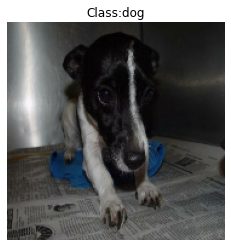

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
plt.imshow(images[i].numpy().astype("uint8"))
plt.title('Class:dog')
plt.axis("off")


Text(0.5, 1.0, 'Resize augmentation comparison')

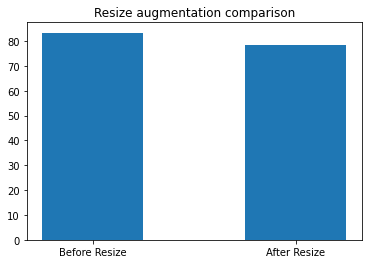

In [ ]:
from matplotlib import pyplot as plt
plt.figure('comparison table of accuracy')
values = [83.38,78.32]
names = ['Before Resize', 'After Resize']
plt.bar(names, values, width=0.5)
plt.title('Resize augmentation comparison')